# Trabalho Final de Machine Learning Aplicado 1

Equipe **GENKIDAMA**

Alunos:
*   Gian Giovanni Rodrigues da Silva
*   Jessyca Jordanna Barroso de Moraes
*   Tammy Hikari Yanai Gusmão
*   Thalita Naiara Andre Alves



## Bibliotecas Utilizadas

In [ ]:
!pip install shap

  Using cached https://files.pythonhosted.org/packages/b9/f4/c5b95cddae15be80f8e58b25edceca105aa83c0b8c86a1edad24a6af80d3/shap-0.39.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/78/c2/b3f55dfdb8af9812fdb9baf70cacf3b9e82e505b2bd4324d588888b81202/slicer-0.0.7-py3-none-any.whl
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=94a88e2c05f413750fbc61a40981b3327712171251018505ab3cf07bb7a669ff
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import shap  #Não está sendo usado
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import statistics as st
from scipy import stats

#from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from matplotlib import colors as mcolors

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree, DecisionTreeClassifier

In [ ]:
pd.options.display.max_columns = None

sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif',
               'fontname': 'Times New Roman'})

##1 - Carregando o Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#paths
path_Dados_Teste = '/content/drive/Shareddrives/ml_aplicado_1/Dados_Teste.csv'
path_Dados_Treino = '/content/drive/Shareddrives/ml_aplicado_1/Dados_Treino.csv'
path_Template_Submissao = '/content/drive/Shareddrives/ml_aplicado_1/Template_Submissao.csv'
path_Dicionario_de_Dados =  '/content/drive/Shareddrives/ml_aplicado_1/Dicionario_de_Dados.csv'

In [ ]:
df_teste_original = pd.read_csv(path_Dados_Teste)

df_treino_original = pd.read_csv(path_Dados_Treino)

df_template = pd.read_csv(path_Template_Submissao)

df_dic = pd.read_csv(path_Dicionario_de_Dados)

In [ ]:
df_teste = df_teste_original.copy()
df_treino = df_treino_original.copy()

In [ ]:
df_teste.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,206833,19,37.0,27.109375,0,Caucasian,F,160.0,Floor,Floor,653,admit,Med-Surg ICU,4.277083,0,69.4,NaN,109.0,108.01,0,0,NaN,30.0,1.56,NaN,4.0,6.0,0.0,5.0,84.0,118.0,23.3,0,128.0,NaN,NaN,NaN,NaN,6.0,134.0,...,NaN,NaN,NaN,NaN,NaN,1.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
1,273200,86,47.0,28.071089,1,Caucasian,M,164.0,Operating Room,Operating Room / Recovery,1035,admit,CCU-CTICU,0.340278,0,75.5,NaN,308.0,1207.01,1,0,NaN,12.0,0.65,0.8,4.0,4.0,0.0,1.0,173.0,93.0,28.6,1,51.0,45.0,45.0,95.0,7.29,28.0,137.0,...,24.0,10.9,10.9,31.8,27.0,1.1,1.1,NaN,NaN,174.0,174.0,4.4,4.3,138.0,137.0,13.9,13.9,57.0,41.0,7.31,7.17,110.0,70.0,180.0,110.0,57.0,45.0,7.29,7.17,110.0,70.0,118.75,110.0,0,0,0,0,0,0,0
2,271053,79,74.0,21.661538,0,Caucasian,F,162.5,Acute Care/Floor,Floor,366,admit,Med-Surg ICU,2.694444,0,57.2,NaN,124.0,305.02,0,0,NaN,24.0,0.46,NaN,4.0,6.0,0.0,5.0,61.0,102.0,18.5,0,48.0,NaN,NaN,NaN,NaN,14.0,144.0,...,NaN,6.3,6.3,18.5,18.5,NaN,NaN,NaN,NaN,258.0,258.0,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
3,221599,120,18.0,17.617188,0,Caucasian,F,160.0,NaN,Accident & Emergency,1000,admit,CCU-CTICU,0.102083,0,45.1,NaN,120.0,407.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,103.0,NaN,0,54.0,NaN,NaN,NaN,NaN,12.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
4,177808,86,80.0,29.880373,0,Caucasian,F,162.6,Emergency Department,Accident & Emergency,1037,admit,SICU,0.114583,0,79.0,NaN,301.0,403.01,0,0,NaN,8.0,0.65,NaN,3.0,6.0,0.0,4.0,106.0,131.0,28.7,0,67.0,NaN,NaN,NaN,NaN,28.0,136.0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0


In [ ]:
df_treino.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,...,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,NaN,...,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


##2 - Funções Originais

As funções abaixo foram criadas para auxiliar no desenvolvimento do notebook e são de uso extenso em todo o documento. Estão situados em uma seção separada para que sua localização seja de mais rápida. 

In [ ]:
#Geração de uma tabela contendo as seguintes informações, dado um dataframe:
# nomes das colunas | seus respectivos tipos | qntd. de valores nulos | qntd. de valores não nulos.

def get_resumo_dataset(_df):
  info_treino = {'colunas': _df.columns,
                'tipos': _df.dtypes,
                'qntd_nulos': _df.isnull().sum(),
                'qntd_nao_nulos': _df.notnull().sum()}
  return pd.DataFrame (info_treino, columns = ['colunas',
                                               'tipos', 
                                               'qntd_nulos', 
                                               'qntd_nao_nulos']).reset_index(drop=True)

In [ ]:
#Função de renderização para a tabela gerada por get_resumo_dataset().

def print_tabulate_resumo_dataset(resumo_dataset):
  print(tabulate(resumo_dataset, headers = 'keys', tablefmt = 'psql')) 

In [ ]:
#Retorna uma series com NaNs preenchidos de acordo com o tipo de dado da series.
#Retorna a própria series recebida caso não haja NaN.
#O preenchimento de NaNs é explicado a seguir: 
#   Serie do tipo float64 recebe a sua respectiva mediana;
#   Serie do tipo object recebe a string "Uninformed";
#   Serie do tipo int64 recebe a sua respectiva moda.

def fill_nans(_series):
  sum = _series.isnull().sum()

  if sum > 0:
    if _series.dtype == 'float64':
      return ( _series.fillna( _series.median() ))
    elif _series.dtype == 'object':
      return ( _series.fillna("Uninformed"))
    else: #int64
      return ( _series.fillna(st.mode(_series) ))
  else: #series passada não tem dados faltantes
    return _series

In [ ]:
#Geração do encoding (formato de series) de dada series especificada
# pelos parâmetros recebidos: 1 dataframe, 1 string (nome da coluna).

def encode_object_att(_df, _column):
  label_encoder = LabelEncoder()
  serie_aux = label_encoder.fit_transform(list(_df[_column].values))
  return serie_aux

In [ ]:
#Normalização da series especificada pelos parâmetros recebidos.
#Se o maior valor numérico da series for 0 (zero), a própria series é retornada.

def normalize_numeric_att(_df, _column):
  series_aux = _df[_column]

  #if series_aux.dtype == 'object':
    #series_aux = series_aux.astype(int)
  
  if np.max(series_aux) != 0:
      return series_aux / np.max(series_aux)
  else:
    return series_aux

##3 - Explorando o Dataset

Esta seção procura explorar o dataset integral (dataframes de treino e teste), afim de definir o tratamento de dados necessário. Os dataframes foram investigados separadamente, dividos em duas subseções.

### 3.1 Dados de Treino

In [ ]:
df_treino.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,...,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,NaN,...,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [ ]:
df_treino.describe()

,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,117141.000000,117141.000000,112658.000000,113098.000000,117141.000000,115268.000000,117141.000000,117141.000000,117141.0,114019.000000,46785.000000,115624.000000,116363.000000,117141.000000,117141.000000,42817.000000,94322.000000,94779.000000,27361.000000,115178.000000,115178.000000,116511.000000,115178.000000,103956.000000,116873.000000,93135.000000,117141.000000,116777.000000,27361.000000,27361.000000,27361.000000,27361.000000,116408.000000,95115.000000,111241.000000,60254.000000,117141.000000,90701.000000,31537.000000,31537.000000,...,24637.000000,24637.000000,24502.000000,24502.000000,44066.000000,44066.000000,10525.000000,10525.000000,21969.000000,21969.000000,26406.000000,26406.000000,25550.000000,25550.000000,21744.000000,21744.000000,41157.000000,41157.000000,40843.000000,40843.000000,41570.000000,41570.000000,33124.000000,33124.000000,20262.000000,20262.000000,20083.000000,20083.000000,20460.000000,20460.000000,15063.000000,15063.000000,117141.000000,117141.000000,117141.000000,117141.000000,117141.000000,117141.000000,117141.000000,117141.000000
mean,213053.294090,106.070880,61.990911,29.108791,0.189609,169.608277,662.333410,0.840681,0.0,83.783195,2.884806,185.448973,565.888574,0.207058,0.027983,1.198471,25.708483,1.480966,0.595690,3.487098,5.483929,0.011441,4.028894,159.994442,99.858659,32.970069,0.156222,87.174911,42.169301,42.169301,132.177782,7.352217,25.140068,137.944758,36.420846,1800.950498,0.330713,12.181481,79.248502,46.977740,...,11.205532,11.090226,33.722006,33.348980,1.576475,1.462497,3.004867,2.955591,194.140926,193.339433,4.188942,4.146969,138.170497,137.884501,13.402073,13.350512,45.345534,38.551370,7.387841,7.323153,165.104368,102.993772,287.448881,223.870124,44.557971,43.362822,7.337705,7.328319,163.159721,146.126252,247.503077,239.633072,0.001041,0.016109,0.013795,0.025439,0.007282,0.004098,0.020710,0.216440
std,38098.195563,63.449333,16.819622,8.279498,0.391993,10.841998,304.300884,2.461198,0.0,25.015740,0.689710,85.847843,466.477434,0.405199,0.164926,2.342894,20.695235,1.545518,0.262992,0.940466,1.271748,0.106349,1.539188,90.526343,30.762695,6.834349,0.363067,41.896179,12.250295,12.250295,85.324899,0.098256,15.016604,5.306728,0.858129,1459.928264,0.470472,6.928058,21.601660,12.770389,...,2.351011,2.381290,6.807910,6.963373,0.945102,0.736226,2.852677,2.813377,92.897650,93.099062,0.761661,0.750339,5.725364,5.673897,6.947965,6.930456,14.588105,11.000094,0.085547,0.111330,107.380896,61.720984,130.400771,119.246185,14.600186,14.035968,0.105544,0.107989,112.987784,100.632113,131.530879,128.715831,0.032255,0.125895,0.116641,0.157456,0.085023,0.063882,0.142413,0.411819
min,147000.000000,1.000000,0.000000,14.844926,0.000000,137.200000,82.000000,-0.25

In [ ]:
print("Qntd. Linhas:", df_treino.shape[0])
print("Qntd. Colunas:", df_treino.shape[1])

Qntd. Linhas: 117141
Qntd. Colunas: 180


#### 3.1.1 Verificação dos Tipos de Dados

In [ ]:
df_treino.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117141 entries, 0 to 117140
Data columns (total 180 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   encounter_id                 int64  
 1   hospital_id                  int64  
 2   age                          float64
 3   bmi                          float64
 4   elective_surgery             int64  
 5   ethnicity                    object 
 6   gender                       object 
 7   height                       float64
 8   hospital_admit_source        object 
 9   icu_admit_source             object 
 10  icu_id                       int64  
 11  icu_stay_type                object 
 12  icu_type                     object 
 13  pre_icu_los_days             float64
 14  readmission_status           int64  
 15  weight                       float64
 16  albumin_apache               float64
 17  apache_2_diagnosis           float64
 18  apache_3j_diagnosis          float64
 19  a

#### 3.1.2 Verificação de Valores Nulos


In [ ]:
resumo_dataset_treino = get_resumo_dataset(df_treino)

#Retirada de coluna desnecessária para esta subseção.
resumo_dataset_treino.drop(['tipos'], axis=1, inplace=True)

print_tabulate_resumo_dataset(resumo_dataset_treino)

+-----+-----------------------------+--------------+------------------+
|     | colunas                     |   qntd_nulos |   qntd_nao_nulos |
|-----+-----------------------------+--------------+------------------|
|   0 | encounter_id                |            0 |           117141 |
|   1 | hospital_id                 |            0 |           117141 |
|   2 | age                         |         4483 |           112658 |
|   3 | bmi                         |         4043 |           113098 |
|   4 | elective_surgery            |            0 |           117141 |
|   5 | ethnicity                   |         1409 |           115732 |
|   6 | gender                      |           57 |           117084 |
|   7 | height                      |         1873 |           115268 |
|   8 | hospital_admit_source       |        29863 |            87278 |
|   9 | icu_admit_source            |          212 |           116929 |
|  10 | icu_id                      |            0 |           1

Foi considerada a possibilidade de retirar todas as linhas (registros) que possuíssem pelo menos um dado faltante. O resultado dessa investigação é observado abaixo:

In [ ]:
limpo_treino = df_treino.dropna()

In [ ]:
print("Quantidade de linhas do dataframe de treino, com NaN:", df_treino.shape[0])
print("Quantidade de linhas do dataframe de treino, sem NaN:", limpo_treino.shape[0])

Quantidade de linhas do dataframe de treino, com NaN: 117141
Quantidade de linhas do dataframe de treino, sem NaN: 54


A retirada de registros contendo pelo menos um NaN foi desconsiderada dada a quantia de registros remanescentes. 

#### 3.1.3 Verificação de Registros Duplicados

Para o dataframe de treino, foi observado que não existem registros duplicados, como explicitado abaixo:

In [ ]:
duplicados_treino = df_treino[df_treino.duplicated(keep='first')]
print("Quantia de duplicatas:", duplicados_treino.shape[0])

Quantia de duplicatas: 0


### 3.2 Dados de Teste

In [ ]:
df_teste.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,206833,19,37.0,27.109375,0,Caucasian,F,160.0,Floor,Floor,653,admit,Med-Surg ICU,4.277083,0,69.4,NaN,109.0,108.01,0,0,NaN,30.0,1.56,NaN,4.0,6.0,0.0,5.0,84.0,118.0,23.3,0,128.0,NaN,NaN,NaN,NaN,6.0,134.0,...,NaN,NaN,NaN,NaN,NaN,1.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
1,273200,86,47.0,28.071089,1,Caucasian,M,164.0,Operating Room,Operating Room / Recovery,1035,admit,CCU-CTICU,0.340278,0,75.5,NaN,308.0,1207.01,1,0,NaN,12.0,0.65,0.8,4.0,4.0,0.0,1.0,173.0,93.0,28.6,1,51.0,45.0,45.0,95.0,7.29,28.0,137.0,...,24.0,10.9,10.9,31.8,27.0,1.1,1.1,NaN,NaN,174.0,174.0,4.4,4.3,138.0,137.0,13.9,13.9,57.0,41.0,7.31,7.17,110.0,70.0,180.0,110.0,57.0,45.0,7.29,7.17,110.0,70.0,118.75,110.0,0,0,0,0,0,0,0
2,271053,79,74.0,21.661538,0,Caucasian,F,162.5,Acute Care/Floor,Floor,366,admit,Med-Surg ICU,2.694444,0,57.2,NaN,124.0,305.02,0,0,NaN,24.0,0.46,NaN,4.0,6.0,0.0,5.0,61.0,102.0,18.5,0,48.0,NaN,NaN,NaN,NaN,14.0,144.0,...,NaN,6.3,6.3,18.5,18.5,NaN,NaN,NaN,NaN,258.0,258.0,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
3,221599,120,18.0,17.617188,0,Caucasian,F,160.0,NaN,Accident & Emergency,1000,admit,CCU-CTICU,0.102083,0,45.1,NaN,120.0,407.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,103.0,NaN,0,54.0,NaN,NaN,NaN,NaN,12.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
4,177808,86,80.0,29.880373,0,Caucasian,F,162.6,Emergency Department,Accident & Emergency,1037,admit,SICU,0.114583,0,79.0,NaN,301.0,403.01,0,0,NaN,8.0,0.65,NaN,3.0,6.0,0.0,4.0,106.0,131.0,28.7,0,67.0,NaN,NaN,NaN,NaN,28.0,136.0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0


In [ ]:
df_teste.describe()

,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,...,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,13016.000000,13016.000000,12511.000000,12569.000000,13016.000000,12812.000000,13016.000000,13016.000000,13016.0,12675.000000,5209.000000,12848.000000,12929.000000,13016.000000,13016.000000,4780.000000,10424.000000,10496.000000,3076.000000,12789.000000,12789.000000,12937.000000,12789.000000,11505.000000,12975.000000,10264.000000,13016.000000,12960.000000,3076.000000,3076.000000,3076.000000,3076.000000,12941.000000,10523.000000,12305.000000,6736.000000,13016.000000,9981.000000,3552.000000,3552.000000,...,2372.000000,2730.000000,2730.000000,2699.000000,2699.000000,4878.000000,4878.000000,1165.000000,1165.000000,2459.000000,2459.000000,2930.000000,2930.000000,2826.000000,2826.000000,2427.000000,2427.000000,4539.000000,4539.000000,4507.000000,4507.000000,4577.000000,4577.000000,3694.000000,3694.000000,2229.000000,2229.000000,2225.000000,2225.000000,2252.000000,2252.000000,1697.000000,1697.000000,13016.000000,13016.000000,13016.000000,13016.000000,13016.000000,13016.000000,13016.000000
mean,212528.930470,106.383374,62.032851,29.123474,0.191918,169.597697,663.282729,0.833205,0.0,83.862256,2.898215,185.886052,566.945813,0.207591,0.028119,1.225858,25.804825,1.487621,0.596137,3.499023,5.492924,0.011440,4.041989,161.469431,99.817341,33.027972,0.160264,87.356455,42.089597,42.089597,131.029519,7.351594,25.245367,137.949796,36.418761,1799.487772,0.327904,12.243834,79.377534,46.898367,...,22.398482,11.191832,11.069963,33.821008,33.357206,1.589653,1.472288,3.238979,3.170235,192.175275,191.194388,4.189365,4.147560,138.137438,137.837438,13.260650,13.210814,45.304428,38.392477,7.386296,7.320642,164.090552,102.627822,288.955785,225.218442,44.507474,43.143450,7.333476,7.322820,161.910293,144.344034,247.723733,239.477880,0.000922,0.015827,0.011832,0.027735,0.007529,0.004994,0.022127
std,38212.588481,63.779753,16.852811,8.111063,0.393824,10.752982,303.900574,2.692954,0.0,24.484960,0.690679,85.953779,466.828471,0.405598,0.165320,2.432100,20.643772,1.525574,0.262340,0.934065,1.264658,0.106349,1.532579,92.260767,30.731919,6.836752,0.366865,42.016716,12.420438,12.420438,81.636530,0.099917,15.097875,5.277910,0.852679,1426.095984,0.469468,6.958007,22.493572,12.432417,...,5.205297,2.347615,2.380992,6.778145,6.970718,0.958824,0.750299,3.277687,3.201089,88.727092,88.975520,0.746857,0.741653,5.586820,5.513365,6.799174,6.776504,14.944907,10.961541,0.086588,0.113315,104.356439,59.610455,129.599359,117.988274,14.914995,14.198704,0.109300,0.114427,109.517704,96.317289,130.670611,127.228009,0.030351,0.124809,0.108132,0.164219,0.086447,0.070493,0.147101
min,147013.000000,1.000000,0.000000,14.844926,0.000000,137.200000,82.000000,-0.172917,0.0,38.600000,1.200000,101.000000,0.090000,0.000000,0.000000,0.100000,4.000000

In [ ]:
print("Qntd. Linhas:", df_teste.shape[0])
print("Qntd. Colunas:", df_teste.shape[1])

Qntd. Linhas: 13016
Qntd. Colunas: 179


#### 3.2.1 Verificação dos Tipos de Dados


In [ ]:
df_teste.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13016 entries, 0 to 13015
Data columns (total 179 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   encounter_id                 int64  
 1   hospital_id                  int64  
 2   age                          float64
 3   bmi                          float64
 4   elective_surgery             int64  
 5   ethnicity                    object 
 6   gender                       object 
 7   height                       float64
 8   hospital_admit_source        object 
 9   icu_admit_source             object 
 10  icu_id                       int64  
 11  icu_stay_type                object 
 12  icu_type                     object 
 13  pre_icu_los_days             float64
 14  readmission_status           int64  
 15  weight                       float64
 16  albumin_apache               float64
 17  apache_2_diagnosis           float64
 18  apache_3j_diagnosis          float64
 19  apa

#### 3.2.2 Verificação de Valores Nulos


In [ ]:
resumo_dataset_teste = get_resumo_dataset(df_teste)

#Retirada de coluna desnecessária para esta subseção.
resumo_dataset_teste.drop(['tipos'], axis=1, inplace=True)

print_tabulate_resumo_dataset(resumo_dataset_teste)

+-----+-----------------------------+--------------+------------------+
|     | colunas                     |   qntd_nulos |   qntd_nao_nulos |
|-----+-----------------------------+--------------+------------------|
|   0 | encounter_id                |            0 |            13016 |
|   1 | hospital_id                 |            0 |            13016 |
|   2 | age                         |          505 |            12511 |
|   3 | bmi                         |          447 |            12569 |
|   4 | elective_surgery            |            0 |            13016 |
|   5 | ethnicity                   |          178 |            12838 |
|   6 | gender                      |            9 |            13007 |
|   7 | height                      |          204 |            12812 |
|   8 | hospital_admit_source       |         3335 |             9681 |
|   9 | icu_admit_source            |           28 |            12988 |
|  10 | icu_id                      |            0 |            

Assim como no dataframe para treino, a retirada de registros contendo pelo menos um valor faltante foi desconsiderada pela drástica diminuição na quantidade de linhas, como é observado abaixo:

In [ ]:
limpo_teste = df_teste.dropna()

In [ ]:
print("Quantidade de linhas do dataframe de teste, com NaN:", df_teste.shape[0])

print("Quantidade de linhas do dataframe de teste, sem NaN:", limpo_teste.shape[0])

Quantidade de linhas do dataframe de teste, com NaN: 13016
Quantidade de linhas do dataframe de teste, sem NaN: 9


#### 3.2.3 Verificação de Registros Duplicados

Para o dataframe de teste, foi observado que não existem registros duplicados, como é explicitado abaixo:

In [ ]:
duplicados_teste = df_teste[df_teste.duplicated(keep='first')]
print("Quantia de duplicatas:", duplicados_teste.shape[0])

Quantia de duplicatas: 0


##4 - Análise de Correlação dos Dados

Uma análise de correlação foi realizada antes do tratamento dos dados, que se encontra na Seção 5. 

A correlação de Pearson foi aplicada ao dataframe de treino. Filtrando os valores de 0.1 à 1, foram selecionadas apenas 18 colunas, como pode ser observado:

In [ ]:
correlacoes = df_treino.corr("pearson")
cor_variaveis = correlacoes.nlargest(177,'diabetes_mellitus')["diabetes_mellitus"][(correlacoes['diabetes_mellitus'] > 0.1) & (correlacoes['diabetes_mellitus'] < 1)]
cor_variaveis

d1_glucose_max       0.399178
glucose_apache       0.352514
h1_glucose_max       0.313336
h1_glucose_min       0.301094
bmi                  0.168682
weight               0.155868
d1_bun_max           0.145741
bun_apache           0.144027
d1_glucose_min       0.137305
h1_bun_min           0.136345
h1_bun_max           0.136287
d1_bun_min           0.135977
d1_creatinine_max    0.126223
d1_creatinine_min    0.123828
creatinine_apache    0.123056
h1_creatinine_min    0.111397
h1_creatinine_max    0.111149
arf_apache           0.106020
Name: diabetes_mellitus, dtype: float64

In [ ]:
print("Qntd. Colunas:",len(cor_variaveis))

Qntd. Colunas: 18


A equipe desenvolvedora realizou um experimento onde o tamanho do dataset de 179 colunas foi reduzido para as 18 colunas retornadas pelo filtro da análise. Neste experimento, o dataframe reduzido foi submetido ao tratamento de dados (Seção 5) e, então, servido aos modelos desenvolvidos (Seção 6) como bases de treinamento e teste. 

Após a análise da performance, isto é, a comparação entre métricas de avaliação, concluíram que não foi satisfatória: os *scores* apresentavam valores baixos (0.50 a 0.69)

Portanto, a análise de correlação não foi considerada para o presente Trabalho Prático. 

##5 - Tratamento dos Dados

A Seção 5 apresenta os métodos de Tratamento dos Dados aplicados no dataset.

###5.1 Redução do Dataset

O primeiro passo realizado foi a identificação e exclusão de colunas que apresentam mais de 50% de dados faltantes. 

In [ ]:
#Verificação de padrões de valores faltantes dentro as colunas.
#A verificação inclui decisão dos próximos passos, dada situação.

def inspect_missing_data(df, data_type = "Train"):
    
    print("--- Dataframe de {} ---".format(data_type))
    
    missing_data = df.isna().sum().reset_index().sort_values(by=0, ascending=False)
    no_missing = missing_data[missing_data[0] != 0].shape[0]
    total_cols = df.shape[1]
    total_rows = df.shape[0]
    
    missing_data.columns = ["name", "missing appearences"]
    missing_data["%missing from total"] = missing_data[missing_data["missing appearences"]!=0]["missing appearences"]/total_rows
    
    too_much_miss = missing_data[missing_data["%missing from total"] > 0.5].shape[0]
    to_drop = missing_data[missing_data["%missing from total"] > 0.5]["name"].values
    
    print("Há {}/{} colunas com dados faltantes.".format(no_missing, total_cols))
    print("Há {}/{} colunas com mais de 50% de dados faltantes. Estas serão retiradas.".format(too_much_miss,
                                                                                                           no_missing))
    
    return missing_data, to_drop

A quantia de colunas que apresentam dados faltantes, independente da porcentagem, e as que apresentam mais de 50% pode ser observada a seguir:

In [ ]:
_, to_drop_train = inspect_missing_data(df=df_treino, data_type="Treino")
_, to_drop_test = inspect_missing_data(df=df_teste, data_type="Teste")

--- Dataframe de Treino ---
Há 160/180 colunas com dados faltantes.
Há 73/160 colunas com mais de 50% de dados faltantes. Estas serão retiradas.
--- Dataframe de Teste ---
Há 160/179 colunas com dados faltantes.
Há 73/160 colunas com mais de 50% de dados faltantes. Estas serão retiradas.


Tendo definido as colunas a serem retiradas, as mesmas são "dropadas":

In [ ]:
df_treino.drop(labels=to_drop_test, axis=1,inplace=True)
df_teste.drop(labels=to_drop_test, axis=1, inplace=True)

O último passo desta subseção representa a retirada de colunas ID: `encounter_id`,`hospital_id` e `icu_id`.

In [ ]:
to_drop = ['encounter_id','hospital_id', 'icu_id']
df_treino.drop(labels=to_drop, axis=1, inplace=True)
df_teste.drop(labels=to_drop, axis=1, inplace=True)

###5.2 Preenchimento de NaNs

Esta subseção trata do preenchimento de lacunas vazias presentes no dataset. 

Sua realização inclui primeiramente a identificação do tipo de dado do atributo em questão.

> Atributo do tipo `float64` recebe a mediana dos valores presentes na coluna.

> Atributo do tipo `object` recebe o valor `"Uninformed"`.

> Atributo do tipo `int64` recebe a moda dos valores presentes na coluna.





A decisão de preencher colunas do tipo `float64` com a mediana é pela melhor  representatividade do valor típico em uma amostra. A mediana não é distorcida por valores extremamente altos ou baixos. Somente um atributo (`pre_icu_los_days`) possui não possui distribuição normal. Porém, o tratamento foi aplicado a todos. 

In [ ]:
#Adquirindo os nomes das colunas do tipo float64.
colunas_float = df_treino.columns[df_treino.dtypes == 'float64']
colunas_float = colunas_float.values
colunas_float = colunas_float.tolist()

In [ ]:
#Execução do teste de Shapiro Wilk
# Primeiro argumento: resultado da estatística.
# O segundo argumento é o valor de p.
# Ho = Os dados apresentam distribuição
# H1 = Os dados não apresentam distribuição normal
# Se o segundo termo (p-valor) é menor que 0,05 (5%) rejeita-se a hipótese nula.

print("A(s) seguinte(s) coluna(s) não apresenta(m) distribuição normal:")
for col in colunas_float:
  result_stats = stats.shapiro(df_treino[col])
  if result_stats[1] < 0.05:
    print("-- {}: {}".format(col, result_stats[1]))

A(s) seguinte(s) coluna(s) não apresenta(m) distribuição normal:
-- pre_icu_los_days: 0.0


p-value may not be accurate for N > 5000.


O método de preenchimento para `object` e `int64` foi escolhido para que o dataset não sofresse alteração grande considerando o seu "intervalo" de possíveis valores.

O preenchimento é responsabilidade da função criada `fill_nans()`.

In [ ]:
#Adquirindo os nomes de todas as colunas.
colunas = df_treino.columns
colunas = colunas.values
colunas = colunas.tolist()
colunas.pop() #retirando o atributo target da lista

'diabetes_mellitus'

In [ ]:
#Preenchimento dos NaNs aplicado aos dataframes.
for col in colunas:
  df_treino[col] = fill_nans(df_treino[col])
  df_teste[col] = fill_nans(df_teste[col])

###5.3 Encoding das Colunas `object`

Após o preenchimento de NaNs, as colunas (de ambos os dataframes) do tipo `object` passaram pelo processo de encoding. 

In [ ]:
#Adquirindo os nomes das colunas do tipo object.
colunas_object = df_treino.columns[df_treino.dtypes == 'object']
colunas_object = colunas_object.values
colunas_object = colunas_object.tolist()

In [ ]:
colunas_object

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type']

In [ ]:
for col in colunas_object:
  df_treino[col] = encode_object_att(df_treino, col)
  df_teste[col] = encode_object_att(df_teste, col)

Após o encoding, as colunas do tipo `object` agora são do tipo `int64`, como pode ser verificado nas tabelas abaixo:

In [ ]:
resumo_dataset_treino = get_resumo_dataset(df_treino[colunas_object])
print("Tabela de Colunas do tipo `object` (df_treino):")
print_tabulate_resumo_dataset(resumo_dataset_treino)

Tabela de Colunas do tipo `object` (df_treino):
+----+-----------------------+---------+--------------+------------------+
|    | colunas               | tipos   |   qntd_nulos |   qntd_nao_nulos |
|----+-----------------------+---------+--------------+------------------|
|  0 | ethnicity             | int64   |            0 |           117141 |
|  1 | gender                | int64   |            0 |           117141 |
|  2 | hospital_admit_source | int64   |            0 |           117141 |
|  3 | icu_admit_source      | int64   |            0 |           117141 |
|  4 | icu_stay_type         | int64   |            0 |           117141 |
|  5 | icu_type              | int64   |            0 |           117141 |
+----+-----------------------+---------+--------------+------------------+


In [ ]:
resumo_dataset_teste = get_resumo_dataset(df_teste[colunas_object])
print("Tabela de Colunas do tipo `object` (df_teste):")
print_tabulate_resumo_dataset(resumo_dataset_teste)

Tabela de Colunas do tipo `object` (df_teste):
+----+-----------------------+---------+--------------+------------------+
|    | colunas               | tipos   |   qntd_nulos |   qntd_nao_nulos |
|----+-----------------------+---------+--------------+------------------|
|  0 | ethnicity             | int64   |            0 |            13016 |
|  1 | gender                | int64   |            0 |            13016 |
|  2 | hospital_admit_source | int64   |            0 |            13016 |
|  3 | icu_admit_source      | int64   |            0 |            13016 |
|  4 | icu_stay_type         | int64   |            0 |            13016 |
|  5 | icu_type              | int64   |            0 |            13016 |
+----+-----------------------+---------+--------------+------------------+


Estas colunas não passaram por mais nenhum tratamento. 

###5.4 Normalização das Colunas `float64`

Após o encoding das colunas do tipo `object`, as colunas do tipo `float64` foram normalizadas. 

A normalização se deu pela divisão de cada valor pelo maior existente na respectiva coluna. Esta foi realizada pela função criada `normalize_numeric_att()`.

In [ ]:
colunas_float = df_treino.columns[df_treino.dtypes == 'float64']
colunas_float = colunas_float.values
colunas_float = colunas_float.tolist()

In [ ]:
for col in colunas_float:
  df_treino[col] = normalize_numeric_att(df_treino, col)
  df_teste[col] = normalize_numeric_att(df_teste, col)

In [ ]:
df_treino.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,...,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,0.764045,0.335218,0,2,1,0.921826,4,1,0,2,0.003084,0,0.397312,0.366883,0.228078,0,0,0.244094,0.224508,0.75,1.0,0.0,0.8,0.280608,0.662921,0.533074,0,0.200,0.600000,0.848101,0.989924,0.166839,0,0.307860,0.412121,0.411111,0.412121,0.411111,0.672316,0.411429,...,0.440678,0.095238,1.00,0.74,0.587444,0.592784,0.587444,0.589744,1.000000,0.954198,0.246032,0.265275,0.787037,0.718447,0.225923,0.224393,0.274959,0.378472,0.475,0.384615,0.517442,0.532934,0.532039,0.548,0.398291,0.417975,0.571429,0.586207,0.860759,0.875817,0.305990,0.344760,0,0,0,0,0,0,0,1
1,0.865169,0.404363,0,2,0,0.818038,4,1,0,5,0.005283,0,0.377419,0.350649,0.092233,0,0,0.070866,0.050089,0.25,0.5,0.0,0.2,0.242191,0.674157,0.717899,0,0.230,0.550000,0.917722,0.884131,0.166839,1,0.277293,0.575758,0.344444,0.575758,0.344444,0.666667,0.411429,...,0.525424,0.148148,0.95,0.70,0.426009,0.365979,0.426009,0.364103,0.918987,0.923664,0.087302,0.079583,0.796296,0.776699,0.063906,0.056350,0.237316,0.444444,0.675,0.666667,0.656977,0.664671,0.716505,0.722,0.952137,0.873621,0.600000,0.655172,0.917722,0.947712,0.505642,0.310529,0,0,0,0,0,0,0,1
2,0.280899,0.471175,0,2,0,0.882969,3,0,0,5,0.000004,0,0.512366,0.396104,0.319407,0,0,0.149606,0.086762,0.75,1.0,0.0,1.0,0.222148,0.573034,0.643969,0,0.340,0.616667,0.873418,0.924433,0.166839,0,0.227729,0.533333,0.533333,0.533333,0.533333,0.542373,0.388571,...,0.338983,0.084656,0.98,0.91,0.663677,0.639175,0.663677,0.635897,0.929114,0.933842,0.150794,0.150323,0.777778,0.796117,0.090009,0.094587,0.245499,0.375000,0.600,0.589744,0.662791,0.652695,0.669903,0.662,0.331624,0.331868,0.600000,0.672414,0.879747,0.901961,0.240885,0.246956,0,0,0,0,0,0,0,0
3,0.910112,0.333784,1,2,0,0.844113,8,2,0,2,0.000004,0,0.331720,0.659091,0.547934,1,0,0.149606,0.086762,1.00,1.0,0.0,1.0,0.309003,0.640449,0.503891,1,0.300,0.066667,0.873418,0.876574,0.166839,1,0.174672,0.290909,0.466667,0.290909,0.466667,0.655367,0.525714,...,0.203390,0.058201,1.00,0.99,0.609865,0.546392,0.582960,0.589744,0.901266,0.885496,0.150794,0.150323,0.777778,0.796117,0.090009,0.094587,0.302782,0.305556,0.600,0.589744,0.674419,0.532934,0.660194,0.518,0.338462,0.077137,0.714286,0.603448,0.879747,0.901961,0.195312,0.195609,0,0,0,0,0,0,0,0
4,0.213483,0.406335,0,2,1,0.961194,15,0,0,5,0.000419,0,0.430108,0.386364,0.273056,0,0,0.149606,0.086762,1.00,1.0,0.0,1.0,0.222148,0.337079,0.643969,0,0.515,0.266667,0.873418,0.924433,0.166839,0,0.227729,0.600000,0.633333,0.600000,0.633333,0.502825,0.342857,...,0.355932,0.084656,1.00,1.00,0.582960,0.618557,0.582960,0.615385,0.929114,0.933842,0.150794,0.150323,0.777778,0.796117,0.090009,0.094587,0.245499,0.375000,0.600,0.589744,0.662791,0.652695,0.669903,0.662,0.331624,0.331868,0.600000,0.672414,0.879747,0.901961,0.240885,0.246956,0,0,0,0,0,0,0,0


In [ ]:
df_teste.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,...,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,0.415730,0.399755,0,2,0,0.818038,4,1,0,5,0.026885,0,0.373118,0.353896,0.049072,0,0,0.236220,0.139535,1.00,1.000000,0.0,1.0,0.140304,0.662921,0.453307,0,0.640,0.100000,0.848101,0.919395,0.167786,0,0.555895,0.703030,0.855556,0.703030,0.855556,0.632768,0.503356,...,0.811594,0.322034,0.1500,0.98,0.97,0.704036,0.768041,0.704036,0.764103,0.926835,0.931552,0.238095,0.265275,0.777778,0.796117,0.140414,0.156975,0.183306,0.291667,0.475,0.487179,0.534884,0.461078,0.549515,0.466,0.403419,0.364158,0.742857,0.896552,0.848101,0.875817,0.552517,0.595628,0,0,0,0,0,0,0
1,0.528090,0.413936,1,2,1,0.838489,7,2,0,0,0.002139,0,0.405914,1.000000,0.548379,1,0,0.094488,0.058140,1.00,0.666667,0.0,0.2,0.288959,0.522472,0.556420,1,0.255,0.466667,0.867089,0.916877,0.447677,1,0.303493,0.387879,0.544444,0.387879,0.544444,0.514124,0.489933,...,0.565217,0.322034,0.2000,1.00,0.98,0.569507,0.432990,0.582960,0.584615,0.926582,0.926209,0.095238,0.088425,0.750000,0.776699,0.075608,0.065406,0.283142,0.343750,0.625,0.615385,0.633721,0.586826,0.617476,0.540,0.297436,0.301372,0.628571,0.689655,0.873418,0.895425,0.301649,0.320309,0,0,0,0,0,0,0
2,0.831461,0.319421,0,2,0,0.830820,0,1,0,5,0.016937,0,0.307527,0.402597,0.138579,0,0,0.188976,0.041145,1.00,1.000000,0.0,1.0,0.101887,0.573034,0.359922,0,0.240,0.233333,0.911392,0.916877,0.146193,0,0.410480,0.490909,0.422222,0.490909,0.422222,0.564972,0.422819,...,0.376812,0.322034,0.2000,1.00,1.00,0.470852,0.376289,0.470852,0.374359,0.929114,0.933842,0.190476,0.212220,0.694444,0.728155,0.041404,0.046287,0.302782,0.211806,0.425,0.435897,0.598837,0.377246,0.576699,0.370,0.441026,0.346219,0.500000,0.568966,0.911392,0.941176,0.407986,0.342315,0,0,0,0,0,0,0
3,0.202247,0.259783,0,2,0,0.818038,13,0,0,0,0.000642,0,0.242473,0.389610,0.184916,0,0,0.149606,0.087657,1.00,1.000000,0.0,1.0,0.223818,0.578652,0.647860,0,0.270,0.200000,0.873418,0.919395,0.167786,0,0.229258,0.539394,0.355556,0.539394,0.355556,0.723164,0.369128,...,0.536232,0.389831,0.1750,1.00,0.99,0.461883,0.530928,0.461883,0.528205,0.929114,0.933842,0.055556,0.061898,0.805556,0.844660,0.053105,0.059369,0.142390,0.302083,0.575,0.589744,0.656977,0.676647,0.685437,0.706,0.340171,0.356983,0.557143,0.672414,0.892405,0.921569,0.112847,0.127146,0,0,0,0,0,0,0
4,0.898876,0.440616,0,2,0,0.831331,3,0,0,7,0.000720,0,0.424731,0.977273,0.183099,0,0,0.062992,0.058140,0.75,1.000000,0.0,0.8,0.177050,0.735955,0.558366,0,0.335,0.466667,0.860759,0.916877,0.174115,0,0.216157,0.648485,0.611111,0.648485,0.611111,0.847458,0.624161,...,0.710145,0.389831,0.2875,0.98,0.98,0.672646,0.773196,0.672646,0.769231,0.934177,0.938931,0.063492,0.061898,0.916667,0.854369,0.062106,0.065406,0.191489,0.333333,0.625,0.564103,0.558140,0.502994,0.660194,0.574,0.372650,0.342632,0.528571,0.603448,0.879747,0.888889,0.245226,0.24

Como pode ser observado abaixo, o dataset está pronto para ser aplicado aos modelos de ML.

In [ ]:
print("Dataframe de Treino:")
resumo_afterTreat_treino = get_resumo_dataset(df_treino)
print_tabulate_resumo_dataset(resumo_afterTreat_treino)

Dataframe de Treino:
+-----+-----------------------------+---------+--------------+------------------+
|     | colunas                     | tipos   |   qntd_nulos |   qntd_nao_nulos |
|-----+-----------------------------+---------+--------------+------------------|
|   0 | age                         | float64 |            0 |           117141 |
|   1 | bmi                         | float64 |            0 |           117141 |
|   2 | elective_surgery            | int64   |            0 |           117141 |
|   3 | ethnicity                   | int64   |            0 |           117141 |
|   4 | gender                      | int64   |            0 |           117141 |
|   5 | height                      | float64 |            0 |           117141 |
|   6 | hospital_admit_source       | int64   |            0 |           117141 |
|   7 | icu_admit_source            | int64   |            0 |           117141 |
|   8 | icu_stay_type               | int64   |            0 |           1171

In [ ]:
print("Dataframe de Teste:")
resumo_afterTreat_teste = get_resumo_dataset(df_teste)
print_tabulate_resumo_dataset(resumo_afterTreat_teste)

Dataframe de Teste:
+-----+-----------------------------+---------+--------------+------------------+
|     | colunas                     | tipos   |   qntd_nulos |   qntd_nao_nulos |
|-----+-----------------------------+---------+--------------+------------------|
|   0 | age                         | float64 |            0 |            13016 |
|   1 | bmi                         | float64 |            0 |            13016 |
|   2 | elective_surgery            | int64   |            0 |            13016 |
|   3 | ethnicity                   | int64   |            0 |            13016 |
|   4 | gender                      | int64   |            0 |            13016 |
|   5 | height                      | float64 |            0 |            13016 |
|   6 | hospital_admit_source       | int64   |            0 |            13016 |
|   7 | icu_admit_source            | int64   |            0 |            13016 |
|   8 | icu_stay_type               | int64   |            0 |            1301

##6 - Aplicação de Modelos de ML

Antes da aplicação dos modelos, é necessário definir as variáveis necessárias para o treino e teste dos modelos.

No entanto, foi constatado que há uma grande desigualdade na quantidade de registros em uma classes, como evidenciado na célula abaixo. Isso foi percebido também após a aplicação dos modelos, ao avaliar *scores*, *classification reports* e matriz de confusão. 

In [ ]:
#Contagem da quantidade de registros de acordo com a confirmação
# de presença ou asência de diabetes.
df_treino.diabetes_mellitus.value_counts()

0    91787
1    25354
Name: diabetes_mellitus, dtype: int64

In [ ]:
X = df_treino.loc[:,df_treino.columns[0]:df_treino.columns[len(df_treino.columns)-2]].values
# df_treino.columns[0] -> primeira coluna do dataframe
# df_treino.columns[len(df_treino.columns)-2] -> penúltima coluna do dataframe

y = df_treino['diabetes_mellitus'].values

Diante da desigualdade na quantia de registros, foi optado pelo *random oversample* da classe minoritária:

In [ ]:
#Definindo estratégia de Over Sample
oversample = RandomOverSampler(sampling_strategy='minority')
X_samp, y_samp = oversample.fit_resample(X, y)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_samp,
                                                    y_samp,
                                                    test_size=0.25,
                                                    random_state=0)

Definindo o *Test Size* de 25%, as amostras de treino e teste foram criadas:

In [ ]:
print('Amostras de treino:')
print(f' * X_train: {X_train.shape}')
print(f' * y_train: {y_train.shape}')

print('Amostras de teste:')
print(f' * X_test: {X_test.shape}')
print(f' * y_test: {y_test.shape}')

Amostras de treino:
 * X_train: (137680, 103)
 * y_train: (137680,)
Amostras de teste:
 * X_test: (45894, 103)
 * y_test: (45894,)


###6.1 Modelos não aplicados

Os modelos que não possuem o método `predict_proba()` não são aplicáveis ao Trabalho Prático, são eles:
*   Árvore de Regressão (DecisionTreeRegressor)
*   Regressão Logística (com Método do Gradiente Estocástico)
*   Regressão Linear
*   Hard Voting
*   Perceptron



###6.2 Regressão Logística

O modelo LogisticRegression recebeu os seguintes parâmetros:

* `max_iter` recebeu um valor alto levando em conta a 
quantidade elevada de registros e colunas e ao *warning* de que o parâmetro era insuficiente; 

* `multi_class = "multinominal'`, pois minimiza perda para perda de entropia cruzada e prevê a distribuição de probabilidade para uma distribuição de probabilidade multinomial, com o intuito de oferecer suporte nativo a problemas de classificação de várias classes. Setando este parâmetro com "multinominal" impossibilita alguns valores de outros parâmetros; 

* `solver` é um dos parâmetros com valores reduzidos pelo `multi_class`. Seu valor é "saga", pois este algoritmo também lida com perda multinominal; 

* `penalty` recebeu "none", pois o padrão ("l2") e os demais possíveis valores não aceitam o `solver = saga`. 

In [ ]:
reglog_model = LogisticRegression(max_iter=900,
                                  multi_class='multinomial',
                                  solver = 'saga',
                                  penalty='none')

In [ ]:
cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(reglog_model, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

In [ ]:
print('Validação Cruzada - Regressão Logística:\n')
print(f'AUC Scores: {n_scores}\n')
print(f'AUC (média): {round(np.mean(n_scores), 4)}')
print(f'AUC (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada - Regressão Logística:

AUC Scores: [0.82503928 0.82287123 0.82149975]

AUC (média): 0.8231
AUC (desvio padrão): 0.0015


In [ ]:
reglog_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=900,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(f'AUC (Treino): {round(roc_auc_score(y_train, reglog_model.predict(X_train)), 5)}')
print(f'AUC (Teste): {round(roc_auc_score(y_test, reglog_model.predict(X_test)), 5)}')

AUC (Treino): 0.74996
AUC (Teste): 0.75206


In [ ]:
print("Classification Report:")
print(classification_report(y_test, reglog_model.predict(X_test), target_names=['No', 'Yes']))

Classification Report:
              precision    recall  f1-score   support

          No       0.73      0.79      0.76     22794
         Yes       0.78      0.71      0.74     23100

    accuracy                           0.75     45894
   macro avg       0.75      0.75      0.75     45894
weighted avg       0.75      0.75      0.75     45894



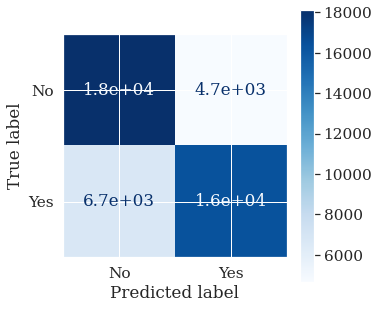

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

cm = confusion_matrix(y_test, reglog_model.predict(X_test), labels=reglog_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pd.Series(reglog_model.classes_).map({0: 'No', 1: 'Yes'}))

disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()

In [ ]:
print("Acurácia Geral da Regressão Logística:")
round(reglog_model.score(X, y), 5) 

Acurácia Geral da Regressão Logística:


0.77342

In [ ]:
print("AUC (Treino) da Regressão Logística aplicada ao dados de treino:")
reglog_auc_treino = round(roc_auc_score(y_train, reglog_model.predict_proba(X_train)[:, 1]), 5)
reglog_auc_treino

AUC (Treino) da Regressão Logística aplicada ao dados de treino:


0.82395

In [ ]:
print("AUC (Teste) da Regressão Logística aplicada ao dados de teste:")
reglog_auc_teste = round(roc_auc_score(y_test, reglog_model.predict_proba(X_test)[:, 1]), 5)
reglog_auc_teste

AUC (Teste) da Regressão Logística aplicada ao dados de teste:


0.82794

In [ ]:
# Aplicando modelo nos dados de teste:
y_pred_reglog = reglog_model.predict_proba(df_teste)

In [ ]:
y_pred_reglog

array([[0.88414183, 0.11585817],
       [0.66995144, 0.33004856],
       [0.59599339, 0.40400661],
       ...,
       [0.80865997, 0.19134003],
       [0.73916164, 0.26083836],
       [0.6249424 , 0.3750576 ]])

In [ ]:
#Gerando o documento.csv contendo o resultado da predição probabilística
#df_template['diabetes_mellitus'] = y_pred_reglog[:,1]
#df_template.to_csv('/content/drive/Shareddrives/ml_aplicado_1/csv_log_tammy/pred_reglog.csv', index = False)

###6.3 KNN Classifier

O modelo KNeighborsClassifier recebeu os seguintes parâmetros:

* `n_neighbors = 19`, pois *n* baixos repercutiam em *scores* baixos;
* `weights = 'distance'`, pois o valor padrão "uniform" aumentava as taxas de erros observáveis pela matriz de confusão;
* `p = 1` para que o *power parameter* utilize a Distância de Manhattan; o valor deste parâmetro é necessária para o `metric`;
* `metric = 'chebyshev'`, pois apresentou maiores acertos de classes corretas;
* `leaf_size = 40`, pois o parâmetro `algorithm` definido para o modelo requer no mínimo o valor 40, sendo que o padrão para leaf_size é 30; 
* `algorithm = 'kd_tree'`, pois o algoritmo KDTree tem a finalidade de reduzir o número necessário de cálculos de distância, codificando de forma eficiente as informações de distância agregadas para a amostra.

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=19, 
                                 weights='distance', 
                                 p=1, 
                                 metric='chebyshev',
                                 leaf_size=40,
                                 algorithm='kd_tree') 

In [ ]:
cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(knn_model, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

In [ ]:
print('Validação Cruzada - KNN:\n')
print(f'Acurácias AUC: {n_scores}\n')
print(f'Acurácia AUC (média): {round(np.mean(n_scores), 4)}')
print(f'Acurácia AUC (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada - KNN:

Acurácias AUC: [0.93338789 0.93820709 0.93398112]

Acurácia AUC (média): 0.9352
Acurácia AUC (desvio padrão): 0.0021


In [ ]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, metric='chebyshev',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=1,
                     weights='distance')

In [ ]:
print(f'AUC (Treino): {round(roc_auc_score(y_train, knn_model.predict(X_train)), 5)}')
print(f'AUC (Teste): {round(roc_auc_score(y_test, knn_model.predict(X_test)), 5)}')

AUC (Treino): 1.0
AUC (Teste): 0.80003


In [ ]:
print("Classification Report:")
print(classification_report(y_test, knn_model.predict(X_test), target_names=['No', 'Yes']))

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.63      0.76     22794
         Yes       0.73      0.97      0.83     23100

    accuracy                           0.80     45894
   macro avg       0.84      0.80      0.79     45894
weighted avg       0.84      0.80      0.80     45894



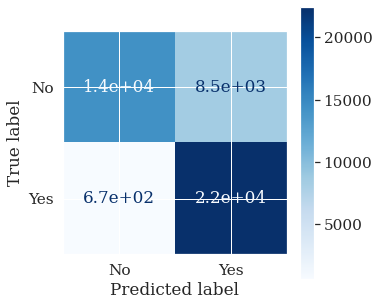

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

cm = confusion_matrix(y_test, knn_model.predict(X_test), labels=knn_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pd.Series(knn_model.classes_).map({0: 'No', 1: 'Yes'}))

disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()

In [ ]:
print("Acurácia Geral do KNN:")
round(knn_model.score(X, y), 5) 

In [ ]:
print("AUC (Treino) do KNN:")
knn_auc_treino = round(roc_auc_score(y_train, knn_model.predict_proba(X_train)[:, 1]), 5)
knn_auc_treino

AUC (Treino) do KNN:


1.0

In [ ]:
# ROC AUC score do modelo aplicado no dados de teste do df_treino_aux
print("AUC predict_proba(amostra de TESTE) do KNN:")
knn_auc_teste = round(roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1]), 5)
knn_auc_teste

AUC predict_proba(amostra de TESTE) do KNN:


0.97572

In [ ]:
# Aplicando modelo nos dados de teste:
y_pred_knn = knn_model.predict_proba(df_teste)

In [ ]:
y_pred_knn

###6.4 Árvore de Decisão

O modelo DecisionTreeClassifier recebeu os seguintes parâmetros:

* `criterion = 'entropy'`, pois é favorável o ganho de informação ao medir a qualidade do split da árvore;
* `max_depth = 20` e `min_samples_split = 2`, pois esta combinação resultou em maiores scores;
* `random_state = 0`, pois não queremos que o estimador permute splits de forma aleatória. 

In [ ]:
dec_tree_model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=20,
                                    min_samples_split=2,
                                    random_state=0)

In [ ]:
cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(dec_tree_model, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

In [ ]:
print('Validação Cruzada - Árvore de Decisão:\n')
print(f'Acurácias: {n_scores}\n')
print(f'Acurácias (média): {round(np.mean(n_scores), 5)}')
print(f'Acurácias (desvio padrão): {round(np.std(n_scores), 5)}')

Validação Cruzada - Árvore de Decisão:

Acurácias: [0.84209642 0.84469767 0.84219073]

Acurácias (média): 0.84299
Acurácias (desvio padrão): 0.0012


In [ ]:
dec_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
print(f'Curva ROC (Treino): {round(roc_auc_score(y_train, dec_tree_model.predict(X_train)), 5)}')
print(f'Curva ROC (Teste): {round(roc_auc_score(y_test, dec_tree_model.predict(X_test)), 5)}')

Curva ROC (Treino): 0.94307
Curva ROC (Teste): 0.86124


In [ ]:
print(classification_report(y_test, dec_tree_model.predict(X_test), target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.93      0.78      0.85     22794
         Yes       0.82      0.94      0.87     23100

    accuracy                           0.86     45894
   macro avg       0.87      0.86      0.86     45894
weighted avg       0.87      0.86      0.86     45894



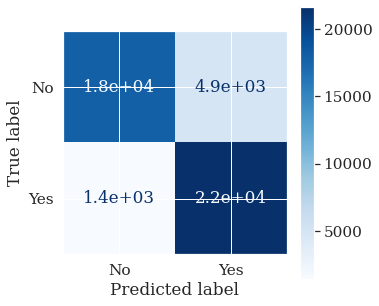

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

cm = confusion_matrix(y_test, dec_tree_model.predict(X_test), labels=dec_tree_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pd.Series(dec_tree_model.classes_).map({0: 'No', 1: 'Yes'}))

disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()

In [ ]:
print("Acurácia Geral da Árvore de Decisão:")
round(dec_tree_model.score(X, y), 5) 

In [ ]:
print("AUC (Treino) da Árvore de Decisão:")
dec_tree_auc_treino = round(roc_auc_score(y_train, dec_tree_model.predict_proba(X_train)[:, 1]), 5)
dec_tree_auc_treino

AUC (Treino) da Árvore de Decisão:


0.986

In [ ]:
print("AUC (Teste) da Árvore de Decisão:")
dec_tree_auc_teste = round(roc_auc_score(y_test, dec_tree_model.predict_proba(X_test)[:, 1]), 5)
dec_tree_auc_teste

AUC (Teste) da Árvore de Decisão:


0.88237

In [ ]:
y_pred_dec_tree

In [ ]:
#df_template['diabetes_mellitus'] = y_pred_dec_tree[:,1]
#df_template.to_csv('/content/drive/Shareddrives/ml_aplicado_1/csv_log_tammy/pred_decisiontree.csv', index = False)

###6.5 Random Forest*

O modelo RandomForestClassifier recebeu os seguintes parâmetros:

* `n_estimators = 30`, valor menor que o padrão (100), mas mostrou melhor performance em relação a valores mais altos;
* `criterion = 'entropy'`, pois é favorável o ganho de informação ao medir a qualidade do split da árvore;
* `max_depth = 15` e `min_samples_split = 2`, pois esta combinação resultou em maiores scores;
* `random_state = 0`, pois não queremos que o estimador permute splits de forma aleatória. 

In [ ]:
random_forest_model = RandomForestClassifier(n_estimators=30, 
                                             criterion='entropy',
                                             max_depth=15,
                                             min_samples_split=2,
                                             random_state=0)

In [ ]:
cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(random_forest_model, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

In [ ]:
print('Validação Cruzada - Random Forest:\n')
print(f'Acurácias AUC: {n_scores}\n')
print(f'Acurácia AUC (média): {round(np.mean(n_scores), 4)}')
print(f'Acurácias AUC (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada - Random Forest:

Acurácias AUC: [0.92363801 0.92109426 0.91783771]

Acurácia AUC (média): 0.9209
Acurácias AUC (desvio padrão): 0.0024


In [ ]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
print(f'AUC Treino: {round(roc_auc_score(y_train, random_forest_model.predict(X_train)), 5)}')
print(f'AUC Teste: {round(roc_auc_score(y_test, random_forest_model.predict(X_test)), 5)}')

AUC Treino: 0.91712
AUC Teste: 0.85873


In [ ]:
print(classification_report(y_test, random_forest_model.predict(X_test), target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.88      0.82      0.85     22794
         Yes       0.84      0.89      0.86     23100

    accuracy                           0.86     45894
   macro avg       0.86      0.86      0.86     45894
weighted avg       0.86      0.86      0.86     45894



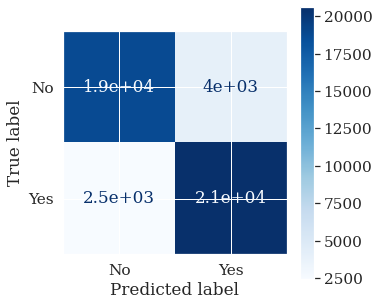

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

cm = confusion_matrix(y_test, random_forest_model.predict(X_test), labels=random_forest_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pd.Series(random_forest_model.classes_).map({0: 'No', 1: 'Yes'}))

disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()

In [ ]:
print("Acurácia Geral da Random Forest:")
round(random_forest_model.score(X, y), 5)

In [ ]:
print("AUC (Treino) da Random Forest:")
random_forest_auc_treino = round(roc_auc_score(y_train, random_forest_model.predict_proba(X_train)[:, 1]), 5)
random_forest_auc_treino

AUC (Treino) da Random Forest:


0.9779

In [ ]:
print("AUC (Teste) da Random Forest:")
random_forest_auc_teste = round(roc_auc_score(y_test, random_forest_model.predict_proba(X_test)[:, 1]), 5)
random_forest_auc_teste

AUC (Teste) da Random Forest:


0.93743

In [ ]:
y_pred_randomForest = random_forest_model.predict_proba(df_teste)

In [ ]:
y_pred_randomForest

In [ ]:
#df_template['diabetes_mellitus'] = y_pred_randomForest[:,1]
#df_template.to_csv('/content/drive/Shareddrives/ml_aplicado_1/csv_log_tammy/pred_randomforest.csv', index = False)

###6.6 Bagging

O modelo BaggingClassifier recebeu os seguintes parâmetros:

* `n_estimators = 100` e `max_samples = 3000`, pois esta configuração apresentou maior performance do modelo, em comparação aos valores padrões. 

In [ ]:
bagging_model = BaggingClassifier(n_estimators=100, max_samples=3000)

In [ ]:
cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(bagging_model, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

In [ ]:
print('Validação Cruzada\n')
print(f'AUCs: {n_scores}\n')
print(f'AUC (média): {round(np.mean(n_scores), 4)}')
print(f'AUCs (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada

AUCs: [0.8492167  0.84746175 0.84539578]

AUC (média): 0.8474
AUCs (desvio padrão): 0.0016


In [ ]:
bagging_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=3000, n_estimators=100,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [ ]:
print(f'AUC (Treino): {round(roc_auc_score(y_train, bagging_model.predict(X_train)), 4)}')
print(f'AUC (Teste): {round(roc_auc_score(y_test, bagging_model.predict(X_test)), 4)}')

AUC (Treino): 0.7856
AUC (Teste): 0.7773


In [ ]:
print(classification_report(y_test, bagging_model.predict(X_test), target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.78      0.77      0.77     22794
         Yes       0.77      0.79      0.78     23100

    accuracy                           0.78     45894
   macro avg       0.78      0.78      0.78     45894
weighted avg       0.78      0.78      0.78     45894



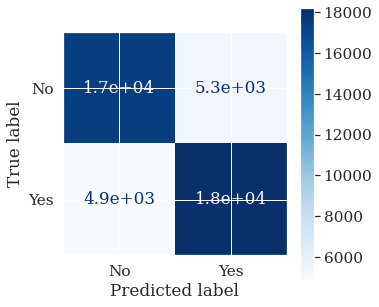

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

cm = confusion_matrix(y_test, bagging_model.predict(X_test), labels=bagging_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pd.Series(bagging_model.classes_).map({0: 'No', 1: 'Yes'}))

disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()

In [ ]:
print("Acurácia Geral do Modelo Bagging:")
round(bagging_model.score(X, y), 5) 

In [ ]:
print("AUC (Treino) do Bagging:")
bagging_auc_treino = round(roc_auc_score(y_train, bagging_model.predict_proba(X_train)[:, 1]), 5)
bagging_auc_treino

AUC (Treino) do Bagging:


0.86303

In [ ]:
print("AUC (Teste) do Bagging:")
bagging_auc_teste = round(roc_auc_score(y_test, bagging_model.predict_proba(X_test)[:, 1]), 5)
bagging_auc_teste

AUC (Teste) do Bagging:


0.85118

In [ ]:
y_pred_bag = bagging_model.predict_proba(df_teste)

In [ ]:
y_pred_bag

In [ ]:
#df_template['diabetes_mellitus'] = y_pred_bag[:,1]
#df_template.to_csv('/content/drive/Shareddrives/ml_aplicado_1/csv_log_tammy/pred_bagging.csv', index = False)

###6.7 Boosting

O modelo AdaBoostClassifier recebeu os seguintes parâmetros:
* `n_estimators = 500`, `learning_rate = 0.5` e `base_estimator` padrão (DecisionTreeClassifier) , pois o modelo faz a predição de forma mais acertiva e o desempenho é mais rápido. O estimador anterior, KNeighborsClassifier, obteve desempenho contrário ao DecisionTreeClassifier. 

In [ ]:
ada_model = AdaBoostClassifier(n_estimators=500, 
                               learning_rate=0.5)

In [ ]:
cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(ada_model, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

In [ ]:
print('Validação Cruzada - AdaBoost:\n')
print(f'AUCs: {n_scores}\n')
print(f'AUC (média): {round(np.mean(n_scores), 4)}')
print(f'AUC (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada - AdaBoost:

AUCs: [0.84780792 0.8457325  0.8448152 ]

AUC (média): 0.8461
AUC (desvio padrão): 0.0013


In [ ]:
ada_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=500, random_state=None)

In [ ]:
print(f'AUC (Treino): {round(roc_auc_score(y_train, ada_model.predict(X_train)), 4)}')
print(f'AUC (Teste): {round(roc_auc_score(y_test, ada_model.predict(X_test)), 4)}')

AUC (Treino): 0.7733
AUC (Teste): 0.7747


In [ ]:
print(classification_report(y_test, ada_model.predict(X_test), target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.77      0.78      0.78     22794
         Yes       0.78      0.77      0.77     23100

    accuracy                           0.77     45894
   macro avg       0.77      0.77      0.77     45894
weighted avg       0.77      0.77      0.77     45894



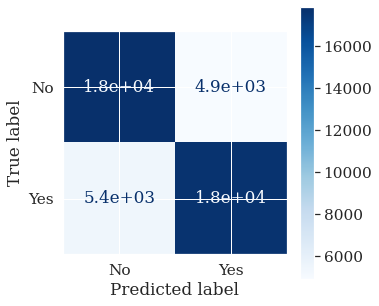

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

cm = confusion_matrix(y_test, ada_model.predict(X_test), labels=ada_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pd.Series(ada_model.classes_).map({0: 'No', 1: 'Yes'}))

disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()

In [ ]:
print("Acurácia Geral do Modelo AdaBoost:")
round(ada_model.score(X, y), 5) 

In [ ]:
print("AUC (Treino) do AdaBoost:")
boosting_auc_treino = round(roc_auc_score(y_train, ada_model.predict_proba(X_train)[:, 1]), 5)
boosting_auc_treino

AUC (Treino) do AdaBoost:


0.84984

In [ ]:
print("AUC (Teste) do AdaBoost:")
boosting_auc_teste = round(roc_auc_score(y_test, ada_model.predict_proba(X_test)[:, 1]), 5)
boosting_auc_teste

AUC (Teste) do AdaBoost:


0.84936

In [ ]:
y_pred_adaboost = ada_model.predict_proba(df_teste)

In [ ]:
y_pred_adaboost

In [ ]:
#df_template['diabetes_mellitus'] = y_pred_adaboost[:,1]
#df_template.to_csv('/content/drive/Shareddrives/ml_aplicado_1/csv_log_tammy/pred_adaboost.csv', index = False)

###6.8 Soft Voting*

O modelo VotingClassifier foi utilizado com o parâmetro `voting = soft` e com os modelos anteriormente utilizados de Regressão Logística, Random Forest, Bagging e AdaBoost. O uso dos modelos de KNN e Árvore de Decisão diminui e sobrecarrega o VotingClassifier. 

In [ ]:
soft_voting_model = VotingClassifier(estimators=[('reglog_model', reglog_model),
                                                 ('random_forest_model', random_forest_model),
                                                 ('bagging_model', bagging_model),
                                                 ('ada_model', ada_model)], 
                                     voting='soft')

In [ ]:
cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(soft_voting_model, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

In [ ]:
print('Validação Cruzada - Soft Voting:\n')
print(f'Acurácias AUC: {n_scores}\n')
print(f'Acurácia AUC (média): {round(np.mean(n_scores), 4)}')
print(f'Acurácias AUC (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada - Soft Voting:

Acurácias AUC: [0.88365414 0.88123816 0.87899462]

Acurácia AUC (média): 0.8813
Acurácias AUC (desvio padrão): 0.0019


In [ ]:
soft_voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('reglog_model',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=900,
                                                 multi_class='multinomial',
                                                 n_jobs=None, penalty='none',
                                                 random_state=None,
                                                 solver='saga', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('random_forest_model',
                              RandomForestClassifier(bootstrap=True...
                                                bootstrap=True,
                                                bootstrap_features=False,
          

In [ ]:
print(f'AUC Treino: {round(roc_auc_score(y_train, soft_voting_model.predict(X_train)), 5)}')
print(f'AUC Teste: {round(roc_auc_score(y_test, soft_voting_model.predict(X_test)), 5)}')

AUC Treino: 0.83751
AUC Teste: 0.8127


In [ ]:
print(classification_report(y_test, soft_voting_model.predict(X_test), target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.82      0.80      0.81     22794
         Yes       0.81      0.82      0.82     23100

    accuracy                           0.81     45894
   macro avg       0.81      0.81      0.81     45894
weighted avg       0.81      0.81      0.81     45894



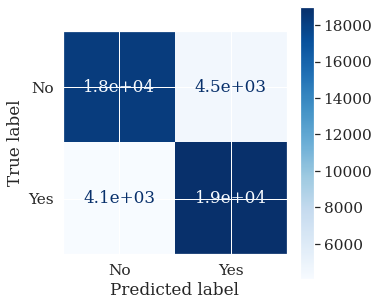

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

cm = confusion_matrix(y_test, soft_voting_model.predict(X_test), labels=soft_voting_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pd.Series(soft_voting_model.classes_).map({0: 'No', 1: 'Yes'}))

disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()

In [ ]:
print("Acurácia do Modelo Soft Voting:")
round(soft_voting_model.score(X, y), 5) 

In [ ]:
print("AUC (Treino) do Soft Voting:")
soft_voting_auc_treino = round(roc_auc_score(y_train, soft_voting_model.predict_proba(X_train)[:, 1]), 5)
soft_voting_auc_treino

AUC (Treino) do Soft Voting:


0.91893

In [ ]:
print("AUC (Teste) do Soft Voting:")
soft_voting_auc_teste = round(roc_auc_score(y_test, soft_voting_model.predict_proba(X_test)[:, 1]), 5)
soft_voting_auc_teste

AUC (Teste) do Soft Voting:


0.89148

In [ ]:
y_pred_soft = soft_voting_model.predict_proba(df_teste)

In [ ]:
y_pred_soft

In [ ]:
#df_template['diabetes_mellitus'] = y_pred_soft[:,1]
#df_template.to_csv('/content/drive/Shareddrives/ml_aplicado_1/csv_log_tammy/pred_softVoting.csv', index = False)

###6.9 Multilayer Perceptron*

O modelo MLPClassifier recebeu os seguintes parâmetros:
* `max_iter = 600` e `random_state = 0` foram mantidas pela performance e taxas de acerto;
* `verbose = 0`, para que mensagens não sejam renderizadas;
* `learning_rate_init = 0.010`, para aumentar levemente a taxa de aprendizado em relação ao padrão (0.001).

In [ ]:
mlp_model = MLPClassifier(max_iter = 600,
                          random_state = 0,
                          verbose = 0,
                          learning_rate_init = 0.010)

In [ ]:
cv = KFold(n_splits = 3, 
           shuffle = True, 
           random_state=0)

n_scores = cross_val_score(mlp_model, 
                           X_train, 
                           y_train, 
                           scoring = 'roc_auc', 
                           cv = cv)

In [ ]:
print('Validação Cruzada - Multilayer Perceptron:\n')
print(f'Acurácias: {n_scores}\n')
print(f'Acurácias (média): {round(np.mean(n_scores), 4)}')
print(f'Acurácias (desvio padrão): {round(np.std(n_scores), 4)}')

Validação Cruzada - Multilayer Perceptron:

Acurácias: [0.84193028 0.83823214 0.83745907]

Acurácias (média): 0.8392
Acurácias (desvio padrão): 0.002


In [ ]:
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.01, max_fun=15000, max_iter=600,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
print(f'AUC (Treino): {round(roc_auc_score(y_train, mlp_model.predict(X_train)), 4)}')
print(f'AUC (Teste): {round(roc_auc_score(y_test, mlp_model.predict(X_test)), 4)}')

AUC (Treino): 0.7677
AUC (Teste): 0.7688


In [ ]:
print(classification_report(y_test, mlp_model.predict(X_test), target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.76      0.79      0.77     22794
         Yes       0.78      0.75      0.76     23100

    accuracy                           0.77     45894
   macro avg       0.77      0.77      0.77     45894
weighted avg       0.77      0.77      0.77     45894



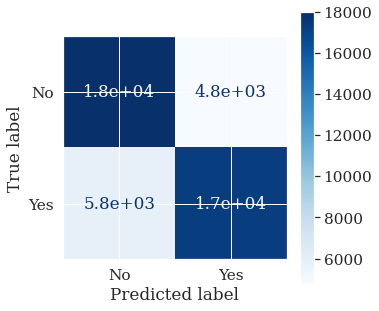

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

cm = confusion_matrix(y_test, mlp_model.predict(X_test), labels=mlp_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pd.Series(mlp_model.classes_).map({0: 'No', 1: 'Yes'}))

disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()

In [ ]:
print("Acurácia do Modelo Multilayer Perceptron:")
round(mlp_model.score(X, y), 5) 

In [ ]:
print("AUC (Treino) do MLP:")
mlp_auc_treino =round(roc_auc_score(y_train, mlp_model.predict_proba(X_train)[:, 1]), 2)
mlp_auc_treino

AUC (Treino) do MLP:


0.85

In [ ]:
print("AUC (Teste) do MLP:")
mlp_auc_teste = round(roc_auc_score(y_test, mlp_model.predict_proba(X_test)[:, 1]), 2)
mlp_auc_teste

AUC (Teste) do MLP:


0.85

In [ ]:
y_pred_mlp = mlp_model.predict_proba(df_teste)

In [ ]:
y_pred_mlp

In [ ]:
#df_template['diabetes_mellitus'] = y_pred_mlp[:,1]
#df_template.to_csv('/content/drive/Shareddrives/ml_aplicado_1/csv_log_tammy/pred_mlp.csv', index = False)

## 7 - Conclusão 

In [ ]:
aucs = [['Regressão Logística', reglog_auc_treino, reglog_auc_teste],
        ['KNN', knn_auc_treino, knn_auc_teste],
        ['Árvore de Decisão', dec_tree_auc_treino, dec_tree_auc_teste],
        ['Random Forest', random_forest_auc_treino, random_forest_auc_teste],
        ['Bagging', bagging_auc_treino, bagging_auc_teste],
        ['Boosting', boosting_auc_treino, boosting_auc_teste],
        ['Soft Voting', soft_voting_auc_treino, soft_voting_auc_teste],
        ['Multilayer Perceptron', mlp_auc_treino, mlp_auc_teste]
       ]

print ("{:<25} {:<25} {:<15}".format('Modelo', 'AUC Treino','AUC Teste'))

for auc in aucs:
    modelo, treino, teste = auc
    print ("{:<25} {:<25} {:<15}".format( modelo, treino, teste))

Modelo                    AUC Treino                AUC Teste      
Regressão Logística       0.82395                   0.82794        
KNN                       1.0                       0.97572        
Árvore de Decisão         0.986                     0.88237        
Random Forest             0.9779                    0.93743        
Bagging                   0.86303                   0.85118        
Boosting                  0.84984                   0.84936        
Soft Voting               0.91893                   0.89148        
Multilayer Perceptron     0.85                      0.85           


Dentre os modelos aplicados, foi observado que os que apresentaram melhor desempenho através do score AUC exibido pela plataforma Kaggle foram **Random Forest**, **Soft Voting** e **Multilayer Perceptron**. 

Os melhores scores AUC, desconsiderando o valor apresentado pelo Kaggle, foram os dos modelos **KNN**, **Random Forest**, **Árvore de Decisão** e **Soft Voting**. Apesar disso, o KNN foi um dos modelos com menores scores submetidos ao Kaggle, além de mostrar ter dificuldade em identificar corretamente os não diabéticos (ver matriz de confusão e valores de *recall* no *classification report*).

Levando em consideração os scores obtidos, os valores no classification report e as matrizes de confusão, o modelo ***Soft Voting*** é o melhor para o problema. O voto por este modelo também é embasado nos modelos utilizados como `estimators`, que não incluem aqueles que tiveram maiores dificuldades em identificar os não-diabéticos (KNN e Árvore de Decisão).